# Investigate a Dataset
# Baseball: Audience and Performance
<small> *This work is done by Adrian Liaw* </small>

In a baseball game, the players control the game, the game stats are the actual performance from the teams and the players; whereas audiences control the atmosphere, the emotions of audiences may indirectly effect the team's performance. The crowd could raise a team's morale by cheering on the team, and vice versa, they could lower a team's morale by booing at them. Now, does the amount of audiences related to a team's performance?

## Q: How does the audiences' attendance of a team related to the team's performance?

*In the following analysis, I'll be using the Lahman's Baseball Database, which can be downloaded [here](http://www.seanlahman.com/baseball-archive/statistics/)*

In [1]:
# These are the libraries we're going to use

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


pd.set_option("display.max_columns", 500) # The data tables have a lot of columns,
                                          # some of them will be replaced by ellipsis in the output display,
                                          # by setting this option, we can avoid that (unless more than 500 columns).
%matplotlib inline

### Loading the Dataset
We need the attendance and performance statistics, which are available via `Teams.csv`

In [2]:
# All the data we need are in Teams.csv

teams = pd.read_csv("Teams.csv")

Let's quickly reveal some samples in the Teams table.  
You can see there's an `attendance` field on the far right.

In [3]:
teams.sample(5)

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,R,AB,H,2B,3B,HR,BB,SO,SB,CS,HBP,SF,RA,ER,ERA,CG,SHO,SV,IPouts,HA,HRA,BBA,SOA,E,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
4,1871,NaN,NY2,NNA,NaN,5,33,NaN,16,17,NaN,NaN,N,NaN,302,1404,403,43,21,1,33,15,46,NaN,NaN,NaN,313,121,3.72,32,1,0,879,373,7,42,22,227,NaN,0.83,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2
1099,1944,NL,PIT,PIT,NaN,2,158,81,90,63,NaN,NaN,N,N,744,5428,1441,248,80,70,573,616,87,NaN,NaN,NaN,662,540,3.44,77,10,19,4242,1466,65,435,452,191,122,0.97,Pittsburgh Pirates,Forbes Field,604278,105,103,PIT,PIT,PIT
1450,1965,AL,NYA,NYY,NaN,6,162,83,77,85,NaN,NaN,N,N,611,5470,1286,196,31,149,489,951,35,20,NaN,NaN,604,532,3.28,41,11,31,4377,1337,126,511,1001,137,166,0.97,New York Yankees,Yankee Stadium I,1213552,99,98,NYY,NYA,NYA
2312,1999,NL,MON,WSN,E,4,162,81,68,94,N,N,N,N,718,5559,1473,320,47,163,438,939,70,51,NaN,NaN,853,747,4.69,6,4,44,4302,1505,152,572,1043,160,126,0.97,Montreal Expos,Stade Olympique,773277,97,98,MON,MON,MON
1043,1941,NL,CHN,CHC,NaN,6,155,77,70,84,NaN,NaN,N,N,666,5230,1323,239,25,99,559,670,39,NaN,NaN,NaN,670,564,3.72,74,8,9,4092,1431,60,449,548,180,139,0.97,Chicago Cubs,Wrigley Field,545159,96,96,CHC,CHN,CHN


## Auditing Data

### Attendance Field
`attendance` field records the home stadium attendance total in the season. Let's have an overview:

In [4]:
teams["attendance"].describe()

count       2496.000000
mean     1330952.239583
std       942469.490606
min         6088.000000
25%       524845.000000
50%      1125288.000000
75%      1984405.500000
max      4483350.000000
Name: attendance, dtype: float64

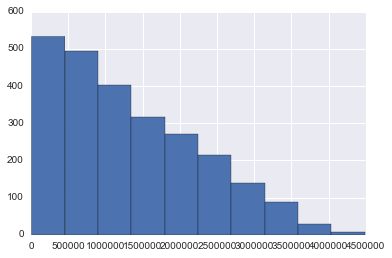

In [5]:
teams["attendance"].hist()
plt.show()

As you can see in the plot, the distribution is highly skewed, like stairs, it seems unnatural. But take a look at this following plot:

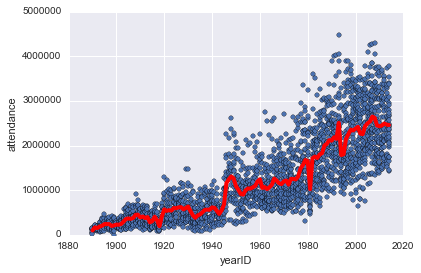

In [6]:
teams.plot("yearID", "attendance", "scatter")
plt.plot(teams.groupby("yearID")["attendance"].mean(), color="r", linewidth=4)
plt.xlim(xmax=2020)
plt.ylim(ymin=0)
plt.show()

It's obvious that `attendance` varies over time, it's getting larger and larger. This may caused by many factors, stadium capacity, urbanisation, transportation, etc. We shouldn't say that "having total attendance of 900000 is small" based on just the value itself, if it happened in 2014, it would be very small; but if it happened in 1900, it would be very large.

So it's a good idea to standardize the data based on the year.

### Standardizing by year
As described above, some variables may vary over time, influenced by factors those consistently making changes.

"Standardize by year" is to turn a value into the z-score of itself in the sample that contains all the observations in the corresponding year. e.g. The standardized value for `attendance` of an observation with `attendance` of 3000000 and `yearID` of 2014 is `0.915`

In [7]:
def standardize_by_year(df, field):
    # The lambda function returns a Series that contains all the standardized values,
    # and the apply method of SeriesGroupBy object concatenates them into a new Series.
    return df.groupby("yearID")[field].apply(lambda g: (g - g.mean()) / g.std(ddof=0))

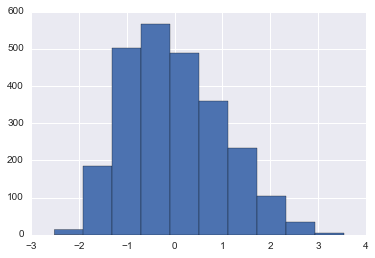

In [8]:
# Now apply it to our dataset
teams["standard_attendance"] = standardize_by_year(teams, "attendance")

teams["standard_attendance"].hist()
plt.show()

It turns out to be a little bit skewed distribution, it's much more reasonable than the original one.

### NAs
All the observations with `yearID < 1890` are all missing `attendance` field, let's just drop them.  
For the rest, just fill `0` into `standard_attendance` since that's the mean value anyway.

In [9]:
teams = teams[teams["yearID"] >= 1890]
teams["standard_attendance"] = teams["standard_attendance"].fillna(0)

## Exploring Relationships

In this analysis, we're exploring the relationship between attendance and performance. Performance can be measured in a variety of ways, runs, hits, homeruns, wins, etc. Let's make some plots and see if there's anything interesting.

### Runs
Runs is the total run scores in the year by a team, and it's available via `R` field. We're expecting there's a positive relationship, since we want to see if teams with more audiences in the game tended to score more.

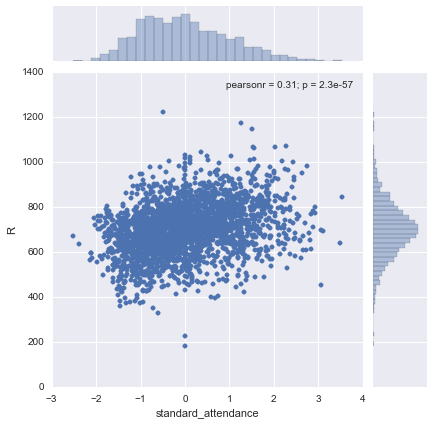

In [10]:
sns.jointplot("standard_attendance", "R", teams)
plt.show()

Here we're actually getting what we're expecting, but it's not so clear that they have a significant positive relationship.

### Errors
Errors is the total errors made by a team in the year, and it's available via `E` field. Now we're expecting to get a negative relationship, since less errors is better.

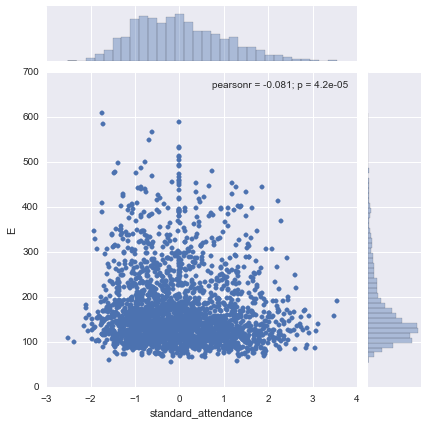

In [11]:
sns.jointplot("standard_attendance", "E", teams)
plt.show()

And it seems no relationship according to our plot.

### Homeruns
Homeruns is the total homeruns made by a team in a year, and it's available via `HR` field. We expect getting a positive relationship.

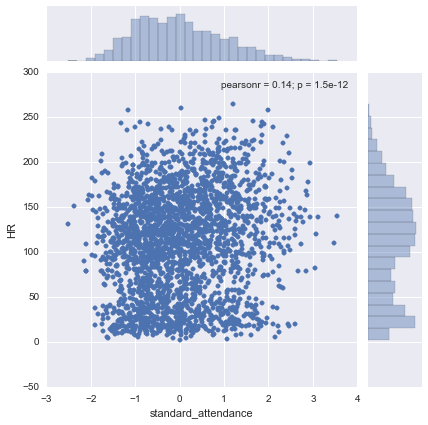

In [12]:
sns.jointplot("standard_attendance", "HR", teams)
plt.show()

But there's clearly no relationship.

### Winning Percentage
Winning percentage is a more general way to measure the team's performance, we're missing this field in our dataset, but the calculation is pretty straight forward.

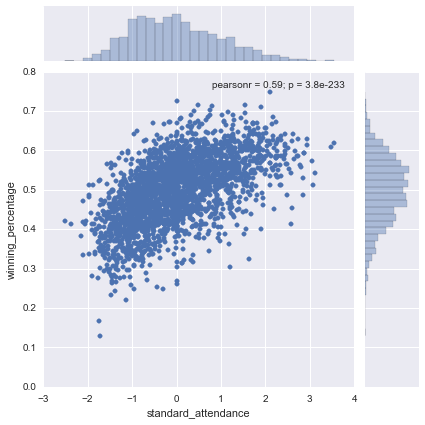

In [13]:
teams["winning_percentage"] = teams["W"] / teams["G"]

sns.jointplot("standard_attendance", "winning_percentage", teams)
plt.show()

It turns out that this relationship is pretty strong. Just by looking at the plot, we can see a positive linear relationship, we're getting Pearson's *r* of 0.59, which is pretty high for a 2538 samples data.

Seaborn also shown us the *p*-value, which is the two-sided *p*-value for a hypothesis test whose null hypothesis is $\rho = 0$ (where $\rho$ is the true correlation for population). The *p*-value shown is $3.8 \times 10^{-233}$, which is approximately $0$, and given an alpha level of $0.01$ (actually, it doesn't matter since the *p*-value is so small), the relationship is considered to be extremely significant.

We can even perform a linear regression and plot the regression line so that we can see how they're actually related:

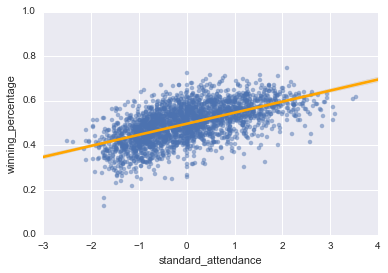

In [14]:
sns.regplot("standard_attendance", "winning_percentage", teams,
            line_kws={"color": "orange"}, scatter_kws={"alpha": 0.5})
plt.ylim(ymax=1)
plt.show()


## Conclusion
According to the above visualizations and statistical summaries, the relationship between audience attendance and team's winning percentage is significant.

And now we can answer the question in the beginning:  
**Q: How does the audiences' attendance of a team related to the team's performance?  
A: The team with more audiences attending the ballgame tend to have a higher winning percentage.**

---

<small>
Resources referred/used:

- https://en.wikipedia.org/wiki/Major_League_Baseball
- http://pandas.pydata.org/pandas-docs/stable/options.html
- http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.jointplot.html#seaborn.jointplot
- http://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html
- http://pandas.pydata.org/pandas-docs/stable/missing_data.html

</small>